In [1]:
from domain_adaptation.datasets import SwaVDataset
import pathlib
import os
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [180, 180])

def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

# labeled_ds = ds.shuffle(1024).map(process_path)

In [3]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [4]:
flowers_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))
flowers_ds = flowers_ds.map(process_path)

In [5]:
a = SwaVDataset.SwaVDataset(flowers_ds, override=False)

In [6]:
ds = a.dataset_swaved

In [7]:
for i in ds.take(1): print(i)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.59092295, 0.59092295, 0.59092295],
        [0.5904287 , 0.5904287 , 0.5904287 ],
        [0.5162968 , 0.5162968 , 0.5162968 ],
        ...,
        [0.429461  , 0.429461  , 0.429461  ],
        [0.43251178, 0.43251178, 0.43251178],
        [0.4325321 , 0.4325321 , 0.4325321 ]],

       [[0.5909537 , 0.5909537 , 0.5909537 ],
        [0.59045976, 0.59045976, 0.59045976],
        [0.5163658 , 0.5163658 , 0.5163658 ],
        ...,
        [0.4294484 , 0.4294484 , 0.4294484 ],
        [0.43248957, 0.43248957, 0.43248957],
        [0.43250978, 0.43250978, 0.43250978]],

       [[0.5955666 , 0.5955666 , 0.5955666 ],
        [0.5951106 , 0.5951106 , 0.5951106 ],
        [0.52672285, 0.52672285, 0.52672285],
        ...,
        [0.4275646 , 0.4275646 , 0.4275646 ],
        [0.4291582 , 0.4291582 , 0.4291582 ],
        [0.42916885, 0.42916885, 0.42916885]],

       ...,

       [[0.37248635, 0.37248635, 0.37248635],
        [0.3

In [10]:
im1, im2, im3, im4, im5 = next(iter(ds.batch(32)))
print(im1.shape, im2.shape, im3.shape, im4.shape, im5.shape)

ValueError: not enough values to unpack (expected 5, got 2)

In [12]:
next(iter(ds.batch(32)))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[4.50540572e-01, 4.50665921e-01, 3.99854094e-01],
          [6.08693361e-01, 6.09704792e-01, 5.38986742e-01],
          [6.56544387e-01, 6.61918342e-01, 5.77581584e-01],
          ...,
          [4.74190474e-01, 4.58886981e-01, 4.95507032e-01],
          [4.37605798e-01, 4.23228800e-01, 4.57277596e-01],
          [3.23662013e-01, 3.12976986e-01, 3.38211626e-01]],
 
         [[6.09264493e-01, 6.09733164e-01, 5.39817274e-01],
          [8.23024452e-01, 8.24897170e-01, 7.27669537e-01],
          [8.87403607e-01, 8.95482481e-01, 7.79847682e-01],
          ...,
          [6.42903507e-01, 6.22028708e-01, 6.71588302e-01],
          [5.93334079e-01, 5.73737502e-01, 6.19804382e-01],
          [4.38848317e-01, 4.24286872e-01, 4.58425939e-01]],
 
         [[6.59798622e-01, 6.62338555e-01, 5.81766903e-01],
          [8.90949309e-01, 8.96030545e-01, 7.84289837e-01],
          [9.59658682e-01, 9.72473979e-01, 8.40814352e-01],
    

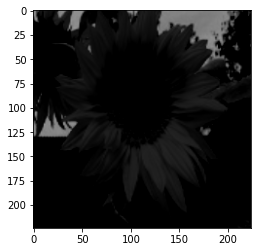

In [46]:
bb = tf.tile(i[0], [1, 1, 3])
plt.imshow(bb, cmap='gray')

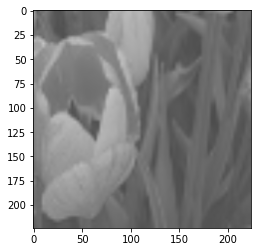

In [8]:
plt.imshow(i[0], cmap='gray')

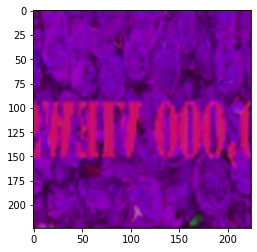

In [9]:
plt.imshow(i[1], cmap='gray')

In [7]:
for i in labeled_ds.take(1): print(i[1])

NameError: name 'labeled_ds' is not defined

In [123]:
tf.io.is_jpeg(i[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

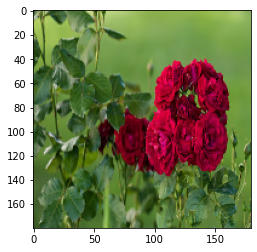

In [37]:
import matplotlib.pyplot as plt

plt.imshow(i[0], cmap='gray')

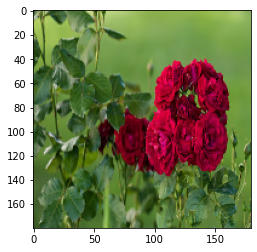

In [43]:
img = tf.expand_dims(i[0], axis=0)
lol = a.gaussian_blur(img=img)
plt.imshow(lol.numpy().squeeze(), cmap='gray')

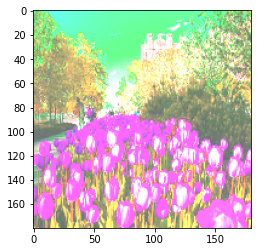

In [158]:
lol2 = a.color_jitter(img=i[0])
plt.imshow(lol2.numpy(), cmap='gray')

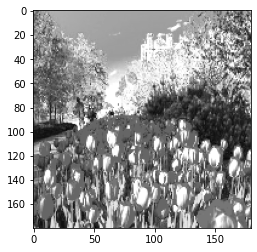

In [165]:
lol3 = a.gray_scale(img=lol2)
plt.imshow(lol3.numpy(), cmap='gray')

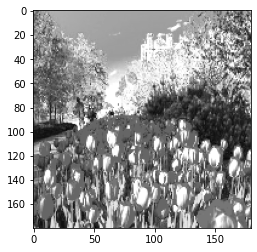

In [166]:
lol4 = a.random_flip(img=lol3)
plt.imshow(lol4.numpy(), cmap='gray')

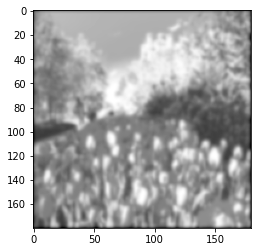

In [175]:
lol5 = tf.expand_dims(lol4, axis=0)
lol = a.gaussian_blur(img=lol5)
plt.imshow(lol.numpy().squeeze(), cmap='gray')

In [109]:
image_shape=img.shape[1]
min_scale=0.5
max_scale=1
crop_size = 96
size = tf.random.uniform(shape=(1,), minval=min_scale*image_shape,
		maxval=max_scale*image_shape, dtype=tf.float32)[0]

In [113]:
tf.squeeze(img, 0)

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.08998305, 0.19316389, 0.07313483],
        [0.31982568, 0.4021496 , 0.21429192],
        [0.2887146 , 0.3830743 , 0.2376761 ],
        ...,
        [0.5325491 , 0.6580393 , 0.3639216 ],
        [0.52688456, 0.65237474, 0.35825706],
        [0.5190414 , 0.6445316 , 0.35097542]],

       [[0.14242557, 0.25350764, 0.12909222],
        [0.24714597, 0.34196076, 0.24575162],
        [0.47122732, 0.5297313 , 0.34899056],
        ...,
        [0.5408861 , 0.66689914, 0.36859852],
        [0.5296732 , 0.66300654, 0.3647059 ],
        [0.52142346, 0.6547568 , 0.35279605]],

       [[0.18465263, 0.27567175, 0.10699589],
        [0.3205519 , 0.40377632, 0.28743646],
        [0.44052285, 0.5220043 , 0.37942386],
        ...,
        [0.54596955, 0.682353  , 0.37124187],
        [0.53435016, 0.6707334 , 0.36572272],
        [0.52244014, 0.6649237 , 0.35381263]],

       ...,

       [[0.21525055, 0.32723305, 0.14490445],
        [0.22

In [110]:
# size = tf.cast(size, tf.int32)
crop = tf.image.random_crop(tf.squeeze(img), (size,size,3))
crop_resize = tf.image.resize(crop, (crop_size, crop_size))

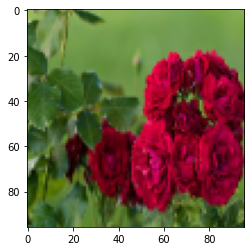

In [111]:
plt.imshow(crop_resize.numpy().squeeze(), cmap='gray')

In [177]:
isinstance(labeled_ds, tf.data.Dataset)

True